In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from torch import Tensor
import math

plt.rcParams["figure.dpi"] = 100

In [52]:
class GaussianFourierTimeEmbedding(nn.Module):
    """Gaussian random features for encoding time steps.

    This is to be used as a utility for score-matching."""

    def __init__(self, embed_dim=256, scale=30.0):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, times: Tensor):
        times_proj = times[:, None] * self.W[None, :] * 2 * math.pi
        embedding = torch.cat([torch.sin(times_proj), torch.cos(times_proj)], dim=-1)
        return torch.squeeze(embedding, dim=1)

class EmbedInputs(nn.Module):
    """Constructs input handler that optionally standardizes and/or
    embeds the input and conditioning variables, as well as the diffusion time
    embedding.
    """

    def __init__(self, embedding_net_x, embedding_net_y, embedding_net_t):
        """Initializes the input handler.

        Args:
            embedding_net_x: Embedding network for x.
            embedding_net_y: Embedding network for y.
            embedding_net_t: Embedding network for time.
        """
        super().__init__()
        self.embedding_net_x = embedding_net_x
        self.embedding_net_y = embedding_net_y
        self.embedding_net_t = embedding_net_t

    def forward(self, x: Tensor, y: Tensor, t: Tensor) -> tuple:
        """Forward pass of the input layer.

        Args:
            inputs: theta (x), x (y), and diffusion time (t).

        Returns:
            Potentially standardized and/or embedded output.
        """

        return (
            self.embedding_net_x(x),
            self.embedding_net_y(y),
            self.embedding_net_t(t),
        )

class MLP(nn.Module):
    """Simple fully connected neural network."""

    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        input_handler: nn.Module,
        hidden_dim: int = 100,
        num_layers: int = 5,
        activation: nn.Module = nn.GELU(),
        layer_norm: bool = True,
        skip_connection: bool = True,
    ):
        """Initializes the MLP.

        Args:
            input_dim: The dimensionality of the input tensor.
            output_dim: The dimensionality of the output tensor.
            input_handler: The input handler module.
            hidden_dim: The dimensionality of the hidden layers.
            num_layers: The number of hidden layers.
            activation: The activation function.
            layer_norm: Whether to use layer normalization.
            skip_connection: Whether to use skip connections.
        """
        super().__init__()

        self.input_handler = input_handler
        self.num_layers = num_layers
        self.activation = activation
        self.skip_connection = skip_connection

        # Initialize layers
        self.layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))

        # Hidden layers
        for _ in range(num_layers - 1):
            if layer_norm:
                block = nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    activation,
                )
            else:
                block = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation)
            self.layers.append(block)

        # Output layer
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x: Tensor, y: Tensor, t: Tensor) -> Tensor:
        x, y, t = self.input_handler(x, y, t)
        xyt = torch.cat([x, y, t], dim=-1)

        h = self.activation(self.layers[0](xyt))

        # Forward pass through hidden layers
        for i in range(1, self.num_layers - 1):
            h_new = self.layers[i](h)
            h = (h + h_new) if self.skip_connection else h_new

        # Output layer
        output = self.layers[-1](h)

        return output


class AdaMLPBlock(nn.Module):
    r"""Creates a residual MLP block module with adaptive layer norm for conditioning.

    Arguments:
        hidden_dim: The dimensionality of the MLP block.
        cond_dim: The number of embedding features.
    """

    def __init__(
        self,
        hidden_dim: int,
        cond_dim: int,
        mlp_ratio: int = 1,
    ):
        super().__init__()

        self.ada_ln = nn.Sequential(
            nn.Linear(cond_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
        )

        # Initialize the last layer to zero
        self.ada_ln[-1].weight.data.zero_()
        self.ada_ln[-1].bias.data.zero_()

        # MLP block
        # NOTE: This can be made more flexible to support layer types.
        self.block = nn.Sequential(
            nn.LayerNorm(hidden_dim, elementwise_affine=False),
            nn.Linear(hidden_dim, hidden_dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(hidden_dim * mlp_ratio, hidden_dim),
        )

    def forward(self, x: Tensor, yt: Tensor) -> Tensor:
        """
        Arguments:
            x: The input tensor, with shape (B, D_x).
            t: The embedding vector, with shape (B, D_t).

        Returns:
            The output tensor, with shape (B, D_x).
        """

        a, b, c = self.ada_ln(yt).chunk(3, dim=-1)

        y = (a + 1) * x + b
        y = self.block(y)
        y = x + c * y
        y = y / torch.sqrt(1 + c * c)

        return y


class AdaMLP(nn.Module):
    """
    MLP denoising network using adaptive layer normalization for conditioning.
    Relevant literature:                                        

    See "Scalable Diffusion Models with Transformers", by William Peebles, Saining Xie.

    Arguments:
        x_dim: The dimensionality of the input tensor.
        emb_dim: The number of embedding features.
        input_handler: The input handler module.
        hidden_dim: The dimensionality of the MLP block.
        num_layers: The number of MLP blocks.
        **kwargs: Key word arguments handed to the AdaMLPBlock.
    """

    def __init__(
        self,
        x_dim: int,
        emb_dim: int,
        input_handler: nn.Module,
        hidden_dim: int = 100,
        num_layers: int = 3,
        **kwargs,
    ):
        super().__init__()
        self.input_handler = input_handler
        self.num_layers = num_layers

        self.ada_blocks = nn.ModuleList()
        for _i in range(num_layers):
            self.ada_blocks.append(AdaMLPBlock(hidden_dim, emb_dim, **kwargs))

        self.input_layer = nn.Linear(x_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, x_dim)

    def forward(self, x: Tensor, y: Tensor, t: Tensor) -> Tensor:
        x, y, t = self.input_handler(x, y, t)
        yt = torch.cat([y, t], dim=-1)

        h = self.input_layer(x)
        for i in range(self.num_layers):        
            h = self.ada_blocks[i](h, yt)
        return self.output_layer(h)


class AdaMLP_Scoring(nn.Module):
    """
    MLP denoising network using adaptive layer normalization for conditioning.
    Relevant literature: https://arxiv.org/abs/2212.09748

    See "Scalable Diffusion Models with Transformers", by William Peebles, Saining Xie.

    Arguments:
        x_dim: The dimensionality of the input tensor.
        emb_dim: The number of embedding features.
        input_handler: The input handler module.
        hidden_dim: The dimensionality of the MLP block.
        num_layers: The number of MLP blocks.
        **kwargs: Key word arguments handed to the AdaMLPBlock.
    """

    def __init__(
        self,
        x_dim: int,
        emb_dim: int,
        input_handler: nn.Module,
        hidden_dim: int = 100,
        num_layers: int = 3,
        **kwargs,
    ):
        super().__init__()
        self.input_handler = input_handler
        self.num_layers = num_layers

        self.ada_blocks = nn.ModuleList()
        for _i in range(num_layers):
            self.ada_blocks.append(AdaMLPBlock(hidden_dim, emb_dim, **kwargs))

        self.input_layer = nn.Linear(x_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, 1)
        # add softplus to output
        self.softplus = nn.Softplus()

    def forward(self, x: Tensor, y: Tensor, t: Tensor) -> Tensor:
        x, y, t = self.input_handler(x, y, t)
        yt = torch.cat([y, t], dim=-1)

        h = self.input_layer(x)
        for i in range(self.num_layers):
            h = self.ada_blocks[i](h, yt)
        return self.softplus(self.output_layer(h))


# TODO adamlp scoring

def build_input_handler(
    t_embedding_dim: int,
    embedding_net_x: nn.Module = nn.Identity(),
    embedding_net_y: nn.Module = nn.Identity(),
) -> nn.Module:
    """Builds input layer for vector field regression, including time embedding, and
    optionally z-scores.

    Args:
        batch_x: Batch of xs, used to infer dimensionality and (optional) z-scoring.
        batch_y: Batch of ys, used to infer dimensionality and (optional) z-scoring.
        t_embedding_dim: Dimensionality of the time embedding.
        z_score_x: Whether to z-score xs passing into the network, can be one of:
            - `none`, or None: do not z-score.
            - `independent`: z-score each dimension independently.
            - `structured`: treat dimensions as related, therefore compute mean and std
            over the entire batch, instead of per-dimension. Should be used when each
            sample is, for example, a time series or an image.
        z_score_y: Whether to z-score ys passing into the network, same options as
            z_score_x.
        embedding_net_x: Optional embedding network for x.
        embedding_net_y: Optional embedding network for y.

    Returns:
        Input handler that provides x, y, and time embedding, and optionally z-scores.
    """

    embedding_net_t = GaussianFourierTimeEmbedding(t_embedding_dim)
    input_handler = EmbedInputs(
        embedding_net_x,
        embedding_net_y,
        embedding_net_t,
    )
    return input_handler


In [ ]:
from sbibm import get_task

task = get_task("two_moons")

prior = task.get_prior_dist()
simulator = task.get_simulator()

# prior samples 
n_samples = 10000
theta = prior.sample((n_samples,))
x = simulator(theta)

plt.scatter(x[:, 0], x[:, 1], s=1)
plt.title("Prior samples")
plt.show()

plt.scatter(theta[:, 0], theta[:, 1], s=1)
plt.title("Prior samples")
plt.show()


/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'plt' is not defined

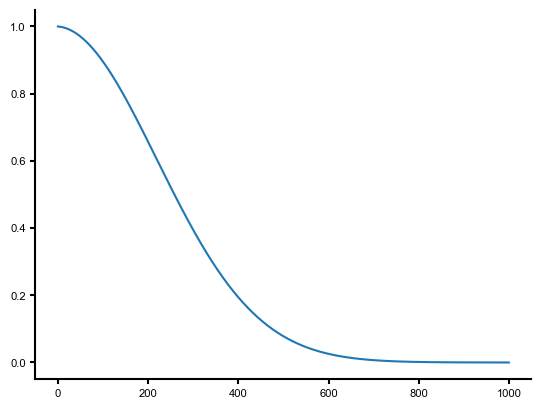

In [54]:
T = 1000  # Number of diffusion timesteps
beta_start = 1e-4
beta_end = 0.02

# Compute beta, alpha, and alpha_bar
betas = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

plt.plot(alphas_bar)
plt.show()

100%|██████████| 1000/1000 [02:23<00:00,  6.97it/s]


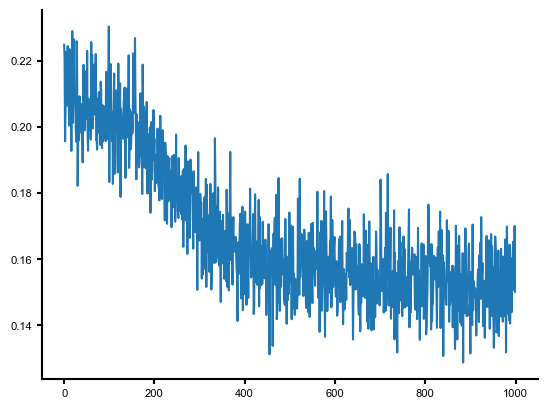

In [80]:
input_handler = build_input_handler(256)
scoring_model = AdaMLP_Scoring(2, 256 + 2, input_handler)
# scoring_model = StandardMLP(2 + 2)
scoring_optimizer = torch.optim.AdamW(scoring_model.parameters(), lr=0.0001)
mse_loss = nn.MSELoss()

train_loss = []
val_loss = []
n_target = 64
train_batch = 128

n_epochs = 1000
for epoch in tqdm(range(n_epochs)):
    theta_batch = prior.sample((train_batch,))
    x_batch = simulator(theta_batch)

    theta_target = prior.sample((n_target * train_batch,))
    x_target = simulator(theta_target)

    theta_batch = theta_batch.repeat(n_target, 1)
    x_batch = x_batch.repeat(n_target, 1)

    target_dist = torch.norm(x_batch - x_target, dim=-1, p=2)   
    # target_dist = torch.square(x_batch - x_target).mean(dim=-1)

    t = torch.from_numpy(np.random.choice(T, size=len(theta_batch)))
    alpha_bar = alphas_bar[t, None]

    gauss = torch.normal(0, 1, size=(theta_batch.shape))
    theta_t = np.sqrt(alpha_bar) * theta_batch + np.sqrt(1 - alpha_bar) * gauss
    # theta_t = theta_batch

    out = scoring_model(theta_t, x_target, t / T)
    loss = mse_loss(target_dist, out.squeeze(1))
    scoring_optimizer.zero_grad()
    loss.backward()
    scoring_optimizer.step()

    train_loss.append(loss.item())

    # TODO add eval again

plt.plot(train_loss)
plt.show()

torch.Size([10000])


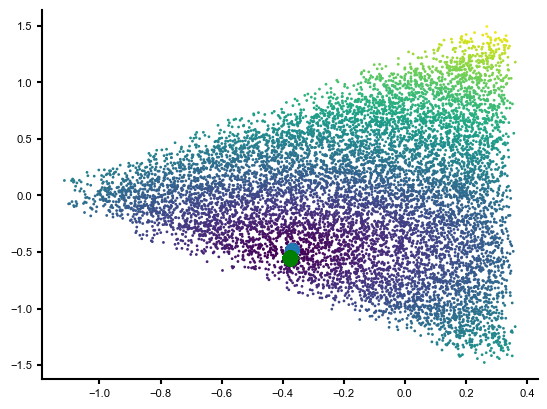

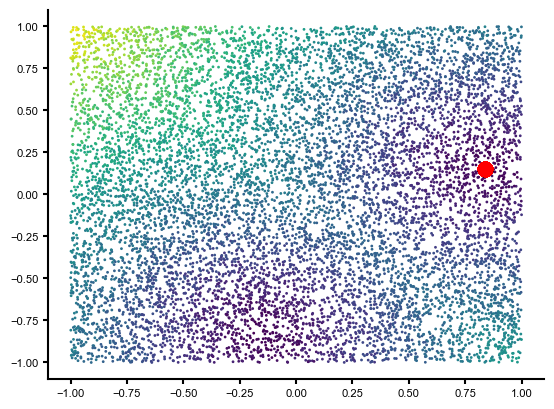

In [67]:
gt_param = prior.sample((1,))
# repeat
gt_param = gt_param.repeat(10000, 1)
x_gt = simulator(gt_param)

x_gt_single = x_gt[:1].repeat(10000, 1)

reference = prior.sample((10000,))
x_ref = simulator(reference)

# compute average distance between x_gt and and each x_ref
heh = []
for obs in x_ref:
    heh.append(torch.norm(x_gt - obs, dim=-1, p=2).mean())

heh = torch.tensor(heh)
print(heh.shape)

plt.scatter(x_ref[:, 0], x_ref[:, 1], c=heh, s=1)
plt.scatter(*x_ref[torch.argmin(heh), :2], s=100)
# plt.scatter(x_gt[:, 0], x_gt[:, 1], c="red", s=1)
plt.scatter(x_gt_single[:, 0], x_gt_single[:, 1], c="green", s=100)
plt.show()

plt.scatter(reference[:, 0], reference[:, 1], c=heh, s=1)
plt.scatter(gt_param[:, 0], gt_param[:, 1], c="red", s=100)
plt.show()

tensor([[0.9999],
        [0.9999],
        [0.9999],
        ...,
        [0.9999],
        [0.9999],
        [0.9999]])


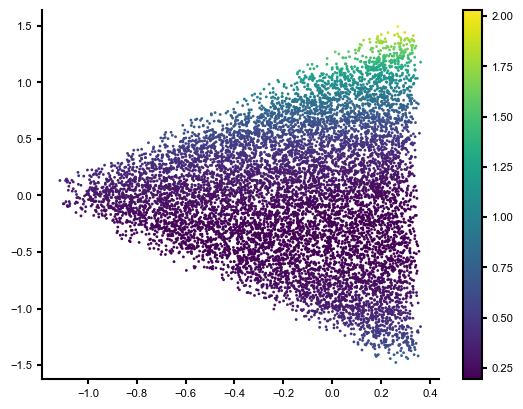

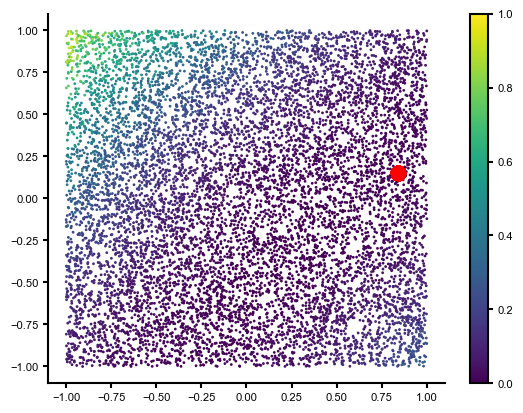

In [68]:

t = (torch.ones(len(gt_param), dtype=int)) * 0
alpha_bar_eval = alphas_bar[t, None]

print(alpha_bar_eval)
gt_param_t = np.sqrt(alpha_bar_eval) * gt_param + np.sqrt(1 - alpha_bar_eval) * torch.normal(0, 1, size=(gt_param.shape))

with torch.no_grad():
    eval_out = scoring_model(gt_param_t, x_ref, t / 1000)

plt.scatter(x_ref[:, 0], x_ref[:, 1], c=eval_out, s=1)
# add colorbar
plt.colorbar()
plt.show()

plt.scatter(reference[:, 0], reference[:, 1], c=eval_out, s=1)
plt.scatter(gt_param[:, 0], gt_param[:, 1], c="red", s=100)
plt.colorbar()
plt.show()

In [58]:
@torch.enable_grad()
def get_classifier_grad(scoring_model, theta_t, x, t):
    theta_t = theta_t.detach()
    x = x.detach()
    t = t.detach()
    theta_t.requires_grad = True
    x.requires_grad = True
    t.requires_grad = True
    out = scoring_model(theta_t, x, t) # .squeeze(1)
    grad = torch.autograd.grad(outputs=out.sum(), inputs=theta_t)[0]
    return grad


100%|██████████| 1000/1000 [00:05<00:00, 191.26it/s]


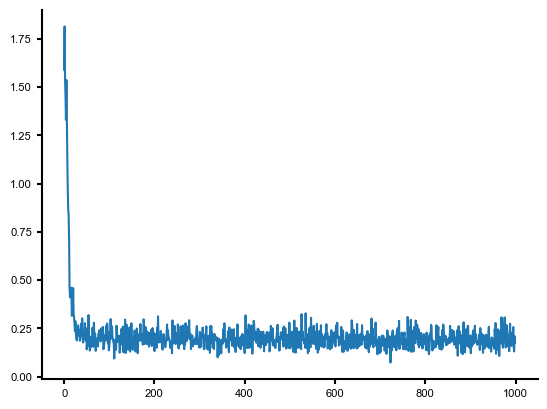

In [59]:
input_handler = build_input_handler(256)
prior_model = AdaMLP(2, 256 + 2, input_handler)
prior_optimizer = torch.optim.AdamW(prior_model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

train_loss = []
val_loss = []
n_target = 64
train_batch = 128

n_epochs = 1000
for epoch in tqdm(range(n_epochs)):
    theta_batch = prior.sample((train_batch,))

    t = torch.from_numpy(np.random.choice(T, size=len(theta_batch)))
    alpha_bar = alphas_bar[t, None]

    gauss = torch.normal(0, 1, size=(theta_batch.shape))
    theta_t = np.sqrt(alpha_bar) * theta_batch + np.sqrt(1 - alpha_bar) * gauss

    dummy = torch.zeros_like(theta_t)
    out = prior_model(theta_t, dummy, t / T)
    loss = mse_loss(out, gauss)
    prior_optimizer.zero_grad()
    loss.backward()
    prior_optimizer.step()

    train_loss.append(loss.item())

    # TODO add eval again

plt.plot(train_loss)
plt.show()

In [69]:

def sample(sample_size, gamma, obs):
    obs = obs[None].repeat((sample_size, 1))
    x_t = torch.normal(0, 1, size=(sample_size, 2))

    for t_idx in tqdm(reversed(range(T))):
        alpha_bar = alphas_bar[t_idx]
        beta = betas[t_idx]
        alpha = alphas[t_idx]

        t = torch.tensor([t_idx]).repeat(sample_size)
        dummy = torch.zeros_like(x_t)
        with torch.no_grad():
            diffusion_step = prior_model(x_t, dummy, t / T)

        z = torch.normal(0, 1, size=(x_t.shape))
        added_noise = np.sqrt(beta) * z if t_idx > 0 else 0  # no noise at the end

        classifier_grad = get_classifier_grad(scoring_model, x_t, obs, t / T)

        x_t = (1 / np.sqrt(alpha)) * (
            x_t
            - (((1 - alpha) / np.sqrt(1 - alpha_bar)) * diffusion_step)
            - beta * gamma * classifier_grad  # scale of 1.0 should work
        ) + added_noise

    return x_t

theta_pred = sample(1000, 1000, x_gt_single[0])

1000it [00:13, 74.12it/s]


torch.Size([10000, 2]) torch.Size([1000, 2])


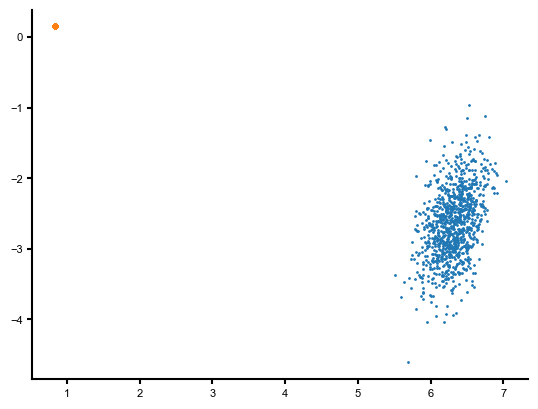

In [70]:
plt.scatter(*theta_pred.numpy().T, s=1)
plt.scatter(*gt_param.numpy().T, s=10)
# plt.show()

print(gt_param.shape, theta_pred.shape)

In [ ]:
task.priorprior = task.get_prior_dist()
simulator = task.get_simulator()

# prior samples
n_samples = 10
theta_val = prior.sample((n_samples,))
x_val = simulator(theta_val)

In [77]:
gammas = [10, 100, 250, 500, 750, 1000]

res = torch.zeros((len(gammas), n_samples, 1000, 2))
for gamma_idx, sample_idx in np.ndindex(len(gammas), n_samples):
    res[gamma_idx, sample_idx] = sample(1000, gammas[gamma_idx], x_val[sample_idx])

1000it [00:13, 72.14it/s]
1000it [00:11, 88.26it/s]
1000it [00:11, 85.61it/s]
1000it [00:11, 89.15it/s]
1000it [00:11, 86.70it/s]
1000it [00:11, 84.59it/s]
1000it [00:11, 88.31it/s]
1000it [00:11, 88.79it/s]
1000it [00:11, 85.15it/s]
1000it [00:11, 85.88it/s]
1000it [00:11, 84.65it/s]
1000it [00:11, 88.57it/s]
1000it [00:11, 89.34it/s]
1000it [00:11, 89.24it/s]
1000it [00:11, 89.14it/s]
1000it [00:11, 89.36it/s]
1000it [00:11, 88.46it/s]
1000it [00:11, 89.17it/s]
1000it [00:11, 89.23it/s]
1000it [00:11, 88.88it/s]
1000it [00:12, 83.18it/s]
1000it [00:11, 83.93it/s]
1000it [00:11, 89.74it/s]
1000it [00:11, 88.57it/s]
1000it [00:11, 88.45it/s]
1000it [00:11, 85.20it/s]
1000it [00:12, 77.59it/s]
1000it [00:11, 84.00it/s]
1000it [00:11, 87.94it/s]
1000it [00:11, 87.94it/s]
1000it [00:11, 86.82it/s]
1000it [00:12, 83.05it/s]
1000it [00:11, 84.64it/s]
1000it [00:11, 88.33it/s]
1000it [00:11, 88.06it/s]
1000it [00:11, 88.19it/s]
1000it [00:11, 87.79it/s]
1000it [00:12, 82.42it/s]
1000it [00:1

tensor([ 0.0920,  1.9138, 13.6112, 26.1459, 34.5593, 40.6264])
tensor([ 0.0452,  1.8339, 14.7490, 27.6652, 36.2573, 43.1198])


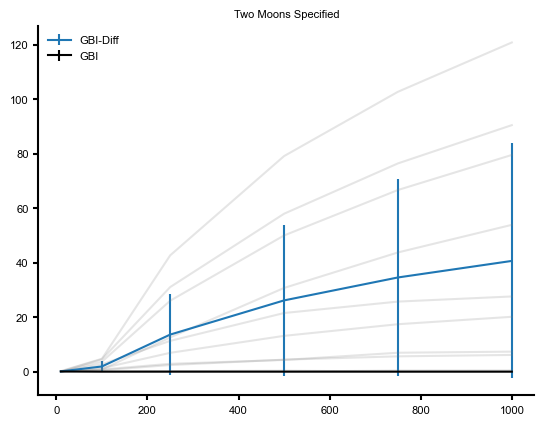

In [78]:
x_res = torch.zeros_like(res)
for gamma_idx, sample_idx in np.ndindex(len(gammas), n_samples):
    x_res[gamma_idx, sample_idx] = simulator(res[gamma_idx, sample_idx])

mse = torch.square(x_res - x_val[None, :, None]).mean(dim=(2, 3))

plt.errorbar(gammas, torch.mean(mse, dim=1), mse.std(dim=1), label="GBI-Diff")
plt.plot(gammas, mse, color="grey", alpha=0.2)
plt.errorbar([10, 100, 1000], np.array([0.081393, 0.017173, 0.006345]), np.array([0.013825,0.003511,0.001873]), c="k", label="GBI")
plt.legend()
plt.title("Two Moons Specified")
# plt.yscale("log")
print(mse.mean(dim=1))
print(mse.std(dim=1))